Import public packages and functions

In [1]:
import os
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from itertools import compress
import re
import seaborn as sns

import openpyxl
from datetime import datetime
from scipy.spatial import distance
from scipy.ndimage import uniform_filter1d
import math
from scipy.signal import find_peaks, peak_prominences
import statistics as stat
import json
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
from sklearn.neighbors import NearestNeighbors

In [2]:
def get_repo_path_in_notebook():
    """
    Finds path of repo from Notebook.
    Start running this once to correctly find
    other modules/functions
    """
    path = os.getcwd()
    repo_name = 'ultraleap_analysis'

    while path[-len(repo_name):] != 'ultraleap_analysis':

        path = os.path.dirname(path)

    return path

In [3]:
repo_path = get_repo_path_in_notebook()
code_path = os.path.join(repo_path, 'code')
os.chdir(code_path)

Import own function

In [4]:
import import_data.import_and_convert_data as import_dat
import import_data.find_paths as find_paths
import import_data.preprocessing_meta_info as meta_info
import sig_processing.segment_tasks as tasks
import movement_calc.helpfunctions as hp
import sig_processing.calc_features as feat_ext

In [5]:
def get_scores(sub, cond, cam, task, side, block):

    read_scores = pd.read_excel(
        os.path.join(
        find_paths.find_onedrive_path('patientdata'),
        f'scores_JB_JH_JR.xlsx'),
        usecols='A:I'
        )

    read_scores.set_index('sub_cond_cam', inplace = True)

    if side == 'left': side='lh'
    elif side == 'right': side='rh'
    
    # read scores for all blocks of a subject in the same cond, cam per side
    ext_scores = read_scores.loc[f'{sub}_{cond}_{cam}'][f'{task}_{side}']

    if type(ext_scores) != float:
        ls_int_sc = [int(s) for s in ext_scores if s in ['0', '1', '2', '3', '4']]
        
        if block == 'b1':
            score = ls_int_sc[0]
        elif block == 'b2':
            score = ls_int_sc[1]
        elif block == 'b3':
            score = ls_int_sc[2]
        else:
            print(f'no scores for block {block} or block does not exist')
        return score

In [6]:
task = 'oc'

In [7]:
df_fts_path = os.path.join(repo_path,
                           'EDA',
                            task,
                            'features.csv'
                            )
df_fts = pd.read_csv(df_fts_path, index_col=0)

In [8]:
df_fts

,file,num_events,mean_max_dist,sd_max_dist,coef_var_max_dist,mean_max_vel,sd_max_vel,coef_var_max_vel,mean_mean_vel,sd_mean_vel,coef_var_mean_vel,mean_deltat,sd_deltat,coef_var_deltat,mean_rms,sd_rms,sum_rms
0,b1_ul001_m1_vr_oc_right.json,19.0,0.109272,0.002220,0.020318,0.784781,0.100015,0.127444,0.261829,0.020189,0.077106,0.478910,0.032191,0.067218,0.072793,0.002686,1.310276
1,b2_ul001_m1_vr_oc_right.json,27.0,0.109855,0.001633,0.014862,1.158742,0.235498,0.203236,0.338435,0.028948,0.085535,0.374461,0.039508,0.105508,0.072942,0.002401,1.896491
2,b1_ul001_m1_dt_oc_right.json,28.0,0.102382,0.001029,0.010052,1.388352,0.181955,0.131058,0.413157,0.041755,0.101062,0.347895,0.036026,0.103555,0.063184,0.003280,1.705966
3,b2_ul001_m1_dt_oc_right.json,25.0,0.101825,0.002750,0.027003,1.476438,0.285087,0.193091,0.409100,0.036075,0.088182,0.351213,0.034020,0.096863,0.061535,0.002103,1.476839
4,b3_ul001_m1_dt_oc_right.json,31.0,0.097874,0.001992,0.020357,1.773567,0.535029,0.301668,0.417906,0.038900,0.093083,0.325432,0.027286,0.083847,0.060389,0.002813,1.811676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,b2_ul020_m1s1_dt_oc_right.json,13.0,0.085574,0.016337,0.190911,1.156129,0.497027,0.429906,0.178521,0.060589,0.339392,0.815451,0.371665,0.455778,0.055987,0.008823,0.671847
165,b1_ul020_m0s0_vr_oc_left.json,9.0,0.055540,0.006010,0.108216,0.121577,0.038430,0.316100,0.032163,0.009566,0.297425,1.073724,0.054028,0.050319,0.046582,0.004308,0.372653
166,b2_ul020_m0s0_vr_oc_left.json,10.0,0.052455,0.007425,0.141559,0.077085,0.044308,0.574790,0.022839,0.011825,0.517751,1.025500,0.347817,0.339168,0.045076,0.002500,0.405682
167,b1_ul020_m1s1_dt_oc_left.json,11.0,0.077444,0.022637,0.292306,0.775401,0.386518,0.498475,0.138888,0.072487,0.521908,0.829317,0.479935,0.578712,0.047152,0.009621,0.471522


In [10]:
ls_file = df_fts['file'].to_list()
ls_scores = []

for file in ls_file:
    del_json = file[:-5]
    split = re.split('_', del_json)
    block = split[0]
    sub = split[1]
    cond = split[2]
    cam = split[3]
    task = split[4]
    side = split[5]

    score = get_scores(sub, cond, cam, task, side, block)
    ls_scores.append(score) # import updrs score for every block (is 'y' for prediction)

In [11]:
df_fts.insert(loc=df_fts.shape[1],column='score',value=ls_scores)

In [9]:
df_fts.dropna(subset=['score'], inplace=True)

KeyError: ['score']

In [10]:
df_fts.describe()

,num_events,mean_max_dist,sd_max_dist,coef_var_max_dist,mean_max_vel,sd_max_vel,coef_var_max_vel,mean_mean_vel,sd_mean_vel,coef_var_mean_vel,mean_deltat,sd_deltat,coef_var_deltat,mean_rms,sd_rms,sum_rms,score
count,169.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,169.000000,142.000000
mean,22.674556,0.079364,0.006117,0.084636,0.821823,0.234128,0.324431,0.208607,0.040804,0.247512,0.505577,0.137687,0.248912,0.053925,0.003921,1.168117,1.838028
std,8.409568,0.015100,0.004505,0.070589,0.437945,0.123544,0.181794,0.105702,0.022603,0.190037,0.248357,0.184545,0.246831,0.008869,0.001903,0.490655,0.777679
min,0.000000,0.040443,0.000000,0.000000,0.038075,0.000000,0.000000,0.009867,0.000000,0.000000,0.222476,0.000000,0.000000,0.034109,0.000000,0.000000,0.000000
25%,18.000000,0.071487,0.002786,0.032869,0.503226,0.147276,0.204643,0.120287,0.022766,0.124038,0.352875,0.042793,0.104742,0.048633,0.002565,0.854940,1.000000
50%,24.000000,0.080515,0.004991,0.068467,0.775401,0.217112,0.279425,0.208060,0.036075,0.181021,0.424230,0.066007,0.163583,0.054412,0.003405,1.165595,2.000000
75%,28.000000,0.089263,0.007779,0.108525,1.076784,0.321060,0.379079,0.276201,0.054820,0.309631,0.566620,0.139131,0.289002,0.058383,0.004911,1.443307,2.000000
max,46.000000,0.109855,0.022730,0.340640,2.341020,0.598055,1.276993,0.481957,0.109432,1.110165,1.957672,1.332785,1.849167,0.101200,0.012186,2.806673,3.000000


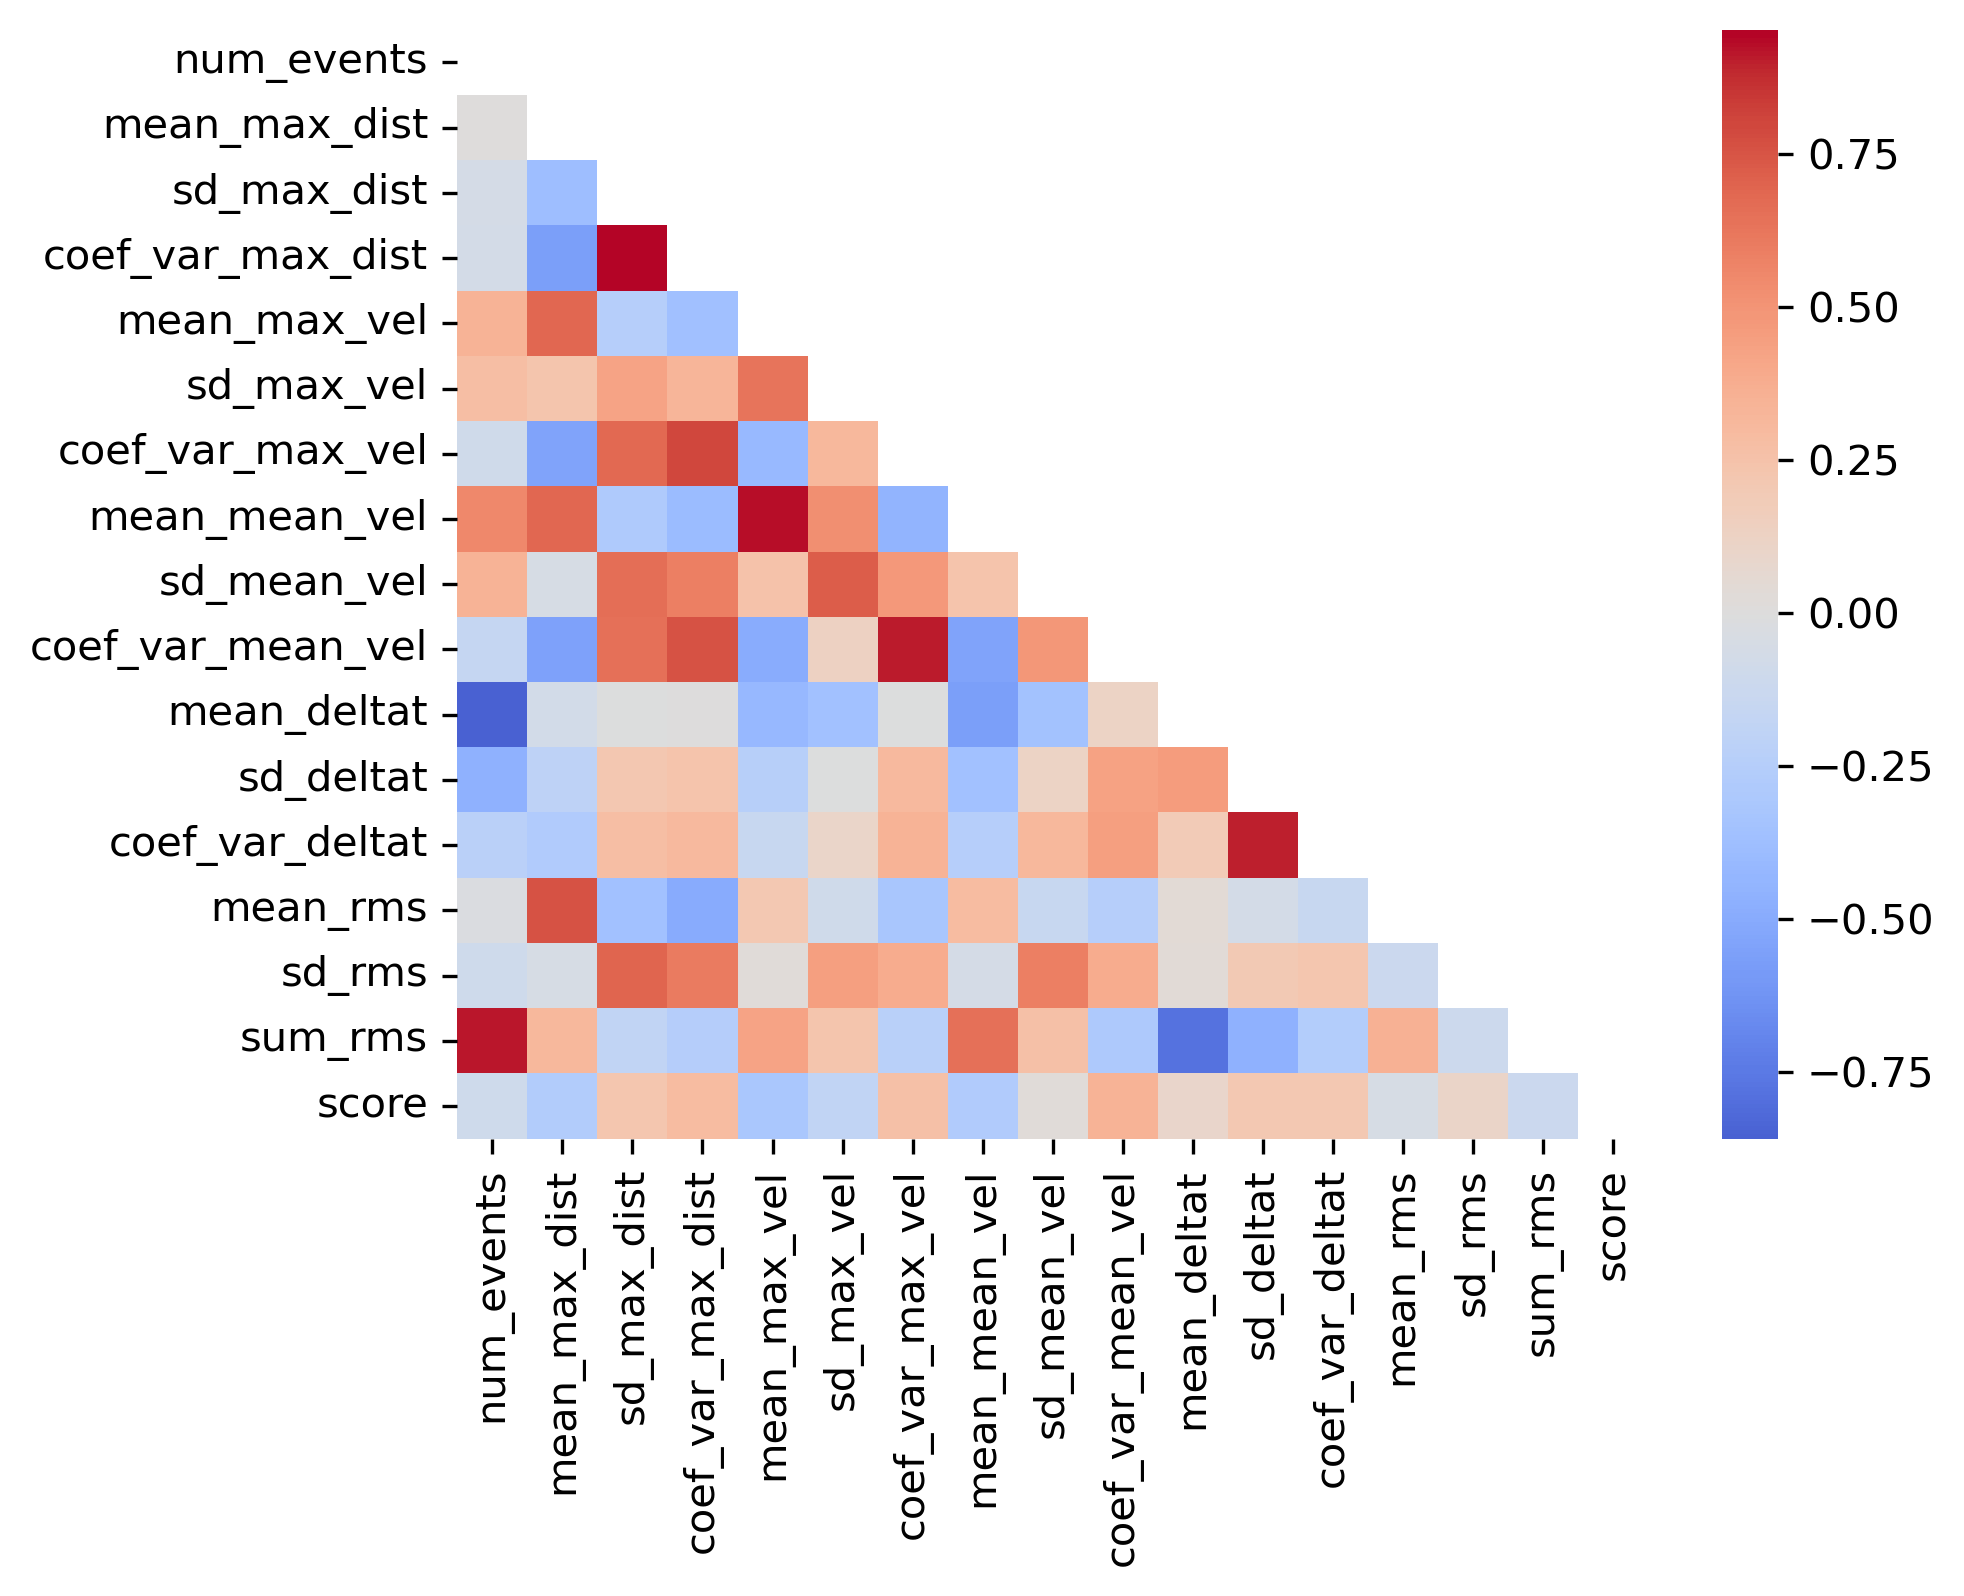

In [11]:
# Load data and create correlation matrix
matrix = df_fts.corr()

# Define mask to hide the upper triangle of the matrix
mask = np.triu(np.ones_like(matrix, dtype=bool))

# Set the center of the colorscheme to 0 and define the color palette
sns.heatmap(matrix, annot=False, mask=mask, center=0, cmap='coolwarm')

# Set the dpi of the figure
plt.gcf().set_dpi(300)